<a href="https://colab.research.google.com/github/Fathimath-Rifna-VK/fmml2021/blob/main/Module_6_FMML_Course_Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Machine Learning: Lab 5 - Modelling Complex Phenomena

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/13VIe5oX_zrmYQl9OmfQ_bZIQmwujMcfA?usp=sharing"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Foundations-in-Modern-Machine-Learning/course-contents/tree/main/Bayesian/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as pg

In [ ]:
plt.style.use("ggplot")

 
# Probabilistic Graphical Models



## Looking at the Problem

Let's try to model a more interesting example, one that concerns the rate at which a user sends and receives text messages:

>  You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this? (This is in fact my own text-message data. Judge my popularity as you wish.)


In [ ]:
messages_sent = np.array([13, 24,  8, 24,  7, 35, 14, 11, 15, 11, 22, 22, 11, 57, 11, 19, 29,  6, 19, 12, 22, 12, 18, 72, 32,  9,  7, 13, 
                          19, 23, 27, 20,  6, 17, 13, 10, 14,  6, 16, 15,  7,  2, 15, 15, 19, 70, 49,  7, 53, 22, 21, 31, 19, 11, 18, 20,
                          12, 35, 17, 23, 17,  4,  2, 31, 30, 13, 27,  0, 39, 37, 5, 14, 13, 22], dtype=np.float)
days = np.arange(1, len(messages_sent) + 1, dtype=np.int)

# Visualizing the Results
fig = px.bar(x=days, y=messages_sent)
fig.show()

## Coming up with a Probabilistic Model

How can we model this?

### The Number of Texts in a Day

A **Poisson random variable** is a very appropriate model for this type of **count data, which lies between 0 and infinity, and has mean probability at some reasonable value, and has a long tail till infinity**. 

Denoting day $i$'s text-message count by $C_i$,  $ C_i \sim \text{Poisson}(\lambda) $.

Let's visualize this distribution and see why it's a good idea. You can see that it looks sort of like a bell curve, but skewed to have a long tail towards infinity and larger less taper towards 0. This is why we often use Poisson variables to **model natural-number valued data which can with negligible probability take a very large value, and it's most probable value is some positive natural number which is not 0**.

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(25, 12))
ax = ax.reshape(-1)
for idx, rate_lambda in enumerate(np.linspace(1, 10, len(ax))):
    samples = tfp.distributions.Poisson(rate=rate_lambda).sample(1000)
    sns.countplot(x=samples.numpy(), ax=ax[idx])
    ax[idx].set_xlim(0, 20)
plt.show()

### Modelling the Rate (or the Mean) of the Poisson Variable

But now what should be the $\lambda$ parameter?
Let's assume we know that there might have been an event, say the start of exams, which changed the value of this parameter.

How can we represent this observation mathematically? 

Let's assume this event, the rise in the number of messages (call it $\tau$). The parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a *switchpoint*:
 
$$\lambda = 
\begin{cases} \lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$


If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal. We are interested in inferring the unknown $\lambda$s. 

$\lambda$ can be any positive number, we need a continuous density function over all postive reals.

But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$. We need to model it too.

$$
\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}
$$

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(25, 12))
ax = ax.reshape(-1)
for idx, rate_alpha in enumerate(np.linspace(1, 10, len(ax))):
    samples = tfp.distributions.Exponential(rate=rate_alpha).sample(1000)
    sns.histplot(x=samples.numpy(), ax=ax[idx], kde=True)
    ax[idx].set_xlim(0, 5)
plt.show()

### Modelling the Rate (or the Mean) of the Exponential Parameter

$\alpha$ is called a *hyper-parameter* or *parent variable*. In literal terms, it is a parameter that influences other parameters. Our initial guess at $\alpha$ does not influence the model too strongly, so we have some flexibility in our choice.  

A good rule of thumb is to **set the exponential parameter equal to the inverse of the average of the count data**. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 

### Modelling the Time of Event

Finally, we get to model $\tau$? Because we cannot see any pattern in the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a *uniform prior belief* to every possible day. This is equivalent to saying
$$
\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}
$$

For the sake of continuing our Probability function visualizations, here is one for the Uniform.

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
samples = tfp.distributions.Uniform(1, 70).sample(10000)
sns.histplot(x=samples.numpy(), ax=ax, kde=True, color="IndianRed")
ax.set_xlim(0, 71)
plt.show()

### And so we have it

That was all our insighe into this problem.

Maybe you feel that you couldn't have come up with it yourself.
And that's perfectly Okay.

There are multiple solutions to such a problem, it takes experience in mathematics to get good results. But once you get it, you have a lot of power in modelling and understanding very complex phenomena.

This is just one solution, motivated by our knowledge of the data. Try to come up with different solutions to model this data yourself and see if things fit.

Let's see if our model gives us some meaningful insight.

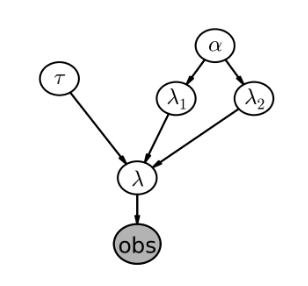

## Back to Solving our Problem

### Introducing TensorFlow Probability

You now define the Probabilistic model with the unknown parameters you need to find. The library, here *Tensorflow Probability*, will run experiments, match the results with the real results, and try to figure out the right values for those parameters.

You **do not** need to understand the process of training, just the way to specify a probability distribution. For details on how probabilistic models can be trained, see:
* https://www.coursera.org/learn/bayesian-methods-in-machine-learning (Course with lecture videos)
* https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers (Interactive Notebooks)


### Specify the Joint Probability Density

We'll assume the data is a consequence of the following generative model:

$$\begin{align*}
\lambda_{1}^{(0)} &\sim \text{Exponential}(\text{rate}=\alpha) \\
\lambda_{2}^{(0)} &\sim \text{Exponential}(\text{rate}=\alpha) \\
\tau &\sim \text{Uniform}[\text{low}=0,\text{high}=1) \\
\text{for }  i &= 1\ldots N: \\
\lambda_i &= \begin{cases} \lambda_{1}^{(0)}, & \tau > i/N \\ \lambda_{2}^{(0)}, & \text{otherwise}\end{cases}\\
 X_i &\sim \text{Poisson}(\text{rate}=\lambda_i)
\end{align*}$$

**The observable variable is $X_i$**, we need to specify it's probability as a function of $\lambda_1$, $\lambda_2$, $\tau$.

This is what is called the **Joint Probability Distribution**.


In [ ]:
count_data = tf.constant(messages_sent, dtype=tf.float32)

def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    # Compute the rate term inside the exponential (match the mean of the real data, since exponential mean is the inverse of rate parameter)
    alpha = (1. / tf.reduce_mean(count_data))

    # Specify two exponential distributions with this rate parameter
    rv_lambda_1 = tfp.distributions.Exponential(rate=alpha)
    rv_lambda_2 = tfp.distributions.Exponential(rate=alpha)

    # Make another random variable with a uniform distribution between 0 and 1
    rv_tau = tfp.distributions.Uniform()

    # The Lambda (parameter of poisson distribution) for each day is selected from Lambda(1) or Lambda(2), based on the value of Tau (all are random variables)
    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.cast(tau * tf.cast(tf.size(count_data), dtype=tf.float32) <= tf.cast(tf.range(tf.size(count_data)), dtype=tf.float32), dtype=tf.int32))
    # The Observerd variable is X, that's what we just computed
    rv_observation = tfp.distributions.Poisson(rate=lambda_)
 
    # Return the sum of log probabilities, which is the same as log of product of probabilities, which is the joint probability of all events happening
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
    )

def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau)

Notice that the implementation is arguably very close to being a 1:1 translation of the mathematical model. The main difference is merely that once we've specified the probabilistic model, we return the sum of the log_probs.

## Getting the Results (Estimating Parameters)

### Running the Sampler

**You DO NOT need to understand the following code**.
It's mostly template code that you will keep copy-pasting. You can find it in the documentation for Tensorflow Probability.

Ignore this section on your first read. Later, come back and try to get a general idea of what is going on. A technique called Hamiltonian Monte Carlo (HMC) is being used to train the model, which is sort of doing the same work that we have done in previous lessons with Expectation Maximization (EM).

In [ ]:
# wrap the mcmc sampling call in a @tf.function to speed it up
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
  return tfp.mcmc.sample_chain(*args, **kwargs)

num_burnin_steps = 5000  # Initially, our model will not have converged, number of steps to wait before we start taking samples.
num_results = 20000  # Number of samples we want to take from our distributions


# Set the chain's start state.
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

step_size = 0.2

kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))


# Sample from the chain.
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = graph_sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_chain_state,
    kernel = kernel)
    
tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(count_data),dtype=tf.float32))

In [ ]:
print("acceptance rate: {}".format(
    tf.reduce_mean(tf.cast(kernel_results.inner_results.inner_results.is_accepted,dtype=tf.float32))))
print("final step size: {}".format(
    tf.reduce_mean(kernel_results.inner_results.inner_results.accepted_results.step_size[-100:])))


The thing to note here is that if acceptance rate is too low, less than 50%, then we failed to draw enough samples after the distribution finished training and converged.

If the final step size is too high, then our model has not converged, if it's too low, it might have gotten a little stuck.

Right now, it seems like we are in a sweet spot. You can change the number of samples your draw and the number of burning steps to fix these issues in case they arrive. Sometimes they are not fixable if your model is too complex.

### Plotting the Parameter Values

We have worked on getting the values of the parameters, let's plot them finall and see if everything is where we expected.

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(3 * 8, 10))
sns.histplot(lambda_1_samples.numpy(), bins=30, ax=ax[0], color="RoyalBlue")
ax[0].set_xlim([15, 30])
ax[0].set_title(r"$\lambda_1$ Probability Distribution")

sns.histplot(lambda_2_samples.numpy(), bins=30, ax=ax[1], color="IndianRed")
ax[1].set_xlim([15, 30])
ax[1].set_title(r"$\lambda_2$ Probability Distribution")

sns.histplot(tau_samples.numpy(), bins=len(count_data), ax=ax[2], color="DarkGreen")
ax[2].set_xticks(np.arange(len(count_data)))
ax[2].set_xlim([35, len(count_data)-20])
ax[2].set_title(r"$\tau$ Probability Distribution")

plt.show()

Clearly, **Lambda 1 and Lambda 2 are not equal, so some major event occured which increased the number of messages**.

In [ ]:
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution

N_ = tau_samples.shape[0]
expected_texts_per_day = tf.zeros((N_, count_data.shape[0])) #(10000,74)

plt.figure(figsize=(18, 9))

day_range = tf.range(0, count_data.shape[0],delta=1,dtype = tf.int32)

# expand from shape of 74 to (10000,74)
day_range = tf.expand_dims(day_range,0)
day_range = tf.tile(day_range,tf.constant([N_,1]))

# expand from shape of 10000 to 10000,74
tau_samples_per_day = tf.expand_dims(tau_samples,0)
tau_samples_per_day = tf.transpose(tf.tile(tau_samples_per_day,tf.constant([day_range.shape[1],1])))

tau_samples_per_day = tf.cast(tau_samples_per_day,dtype=tf.int32)
#ix_day is (10000,74) tensor where axis=0 is number of samples, axis=1 is day. each value is true iff sampleXday value is < tau_sample value
ix_day = day_range < tau_samples_per_day

lambda_1_samples_per_day = tf.expand_dims(lambda_1_samples,0)
lambda_1_samples_per_day = tf.transpose(tf.tile(lambda_1_samples_per_day,tf.constant([day_range.shape[1],1])))
lambda_2_samples_per_day = tf.expand_dims(lambda_2_samples,0)
lambda_2_samples_per_day = tf.transpose(tf.tile(lambda_2_samples_per_day,tf.constant([day_range.shape[1],1])))

expected_texts_per_day = ((tf.reduce_sum(lambda_1_samples_per_day*tf.cast(ix_day,dtype=tf.float32),axis=0) + 
                           tf.reduce_sum(lambda_2_samples_per_day*tf.cast(~ix_day,dtype=tf.float32),axis=0))/N_)

plt.plot(range(count_data.shape[0]), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, count_data.shape[0])
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#5DA5DA", alpha=0.65, label="observed texts per day")

plt.legend(loc="upper left");

Even in the very noisy data, our model has found a change in the parameter values, with reasonable confidence. This seems an impressive deal and a very explainable achievement in AI.

This tutorial has been adapted from https://colab.research.google.com/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_TFP.ipynb.

The data is the real text message count of the author. The 45th day, where we see the switch of our Bayesian switchpoint model, is infact Christmas, when he moved to Toronto and texts to his girlfriend back home in the US increased.